# Beams Pipeline Tutorial

## What software do I need for this tutorial?

Welcome to the Beams Pipeline Tutorial! Before beginning, you will need the Map Multi Tool, as well as the beam systematics files.

To get the Map Multi Tool on your computer, go to your command line or terminal and paste in:

```git clone https://github.com/CMB-S4/map_multi_tool.git```

For the beam systematics, paste in:

```git clone https://github.com/laurensaunders/beams_pipeline.git```

You will also need ```numpy```, ```scipy```, ```matplotlib```, ```math```, and ```time```, so make sure that each of those is also installed on your computer.

Before you get started on the tutorial, you will need to open ```mmt_tools.py``` and update line 5 so that ```path_prefix``` points to the directory that contains ```beams_pipeline```. If ```map_multi_tool``` is also in that directory, you will not need to do anything else; otherwise, follow the instructions in the README file.

## Introduction to Beams

### What do beams and beam perturbations look like in map space?

When we study our beams, we look at the Stokes I, Q, U, and V parameters, although for most experiments we do not expect a signficant V parameter component. In the case of a completely perfect beam, we expect our beam to be a perfect 2-dimensional Gaussian, with no leakage in any of the components:

<div>
<img src="img/gaussian_beam_example.png" width="500" alt="Unperturbed Gaussian beam"/>
</div>

Perfect beams, though, do not generally exist on real experiments, so we need to look at how different aberrations produce leakage in our maps. There are a few common ways that imperfections in the telescope optical system can make these imperfections.

First, let's think about what happens when we have a difference of main-beam full width at half maximum (FWHM)--for example, in detectors that are pair-differenced. In this case, when we look at the difference, we see a ring shape around the center of the beam, called a monopole:

<div>
<img src="img/monopole_beam_example.png" width="500" alt="Monopole perturbation of a beam"/>
</div>

When we have differential pointing, the beam may create a double-lobed, or dipole, pattern:

<div>
<img src="img/dipole_beam_example.png" width="500" alt="Dipole perturbation of a beam"/>
</div>

And when we have differential ellipticities in a pair-differenced set of detectors, the beam creates a 4-lobed, or quadrupole, pattern:

<div>
<img src="img/quadrupole_beam_example.png" width="500" alt="Quadrupole perturbation of a beam"/>
</div>

These effects are added to the beam, which creates a more complicated beam shape. Additionally, due to reflections, misalignment, or crosstalk, we sometimes see a ghost beam, which looks like a copy of the main beam that shows up away from the center of the main beam:

<div>
<img src="img/ghost_beam_example.png" width="500" alt="Gaussian beam with a ghost in the lower right corner"/>
</div>

The size scales of the features in the beam correspond to the $\ell$ scales on which they appear when we look at the power spectra.

### Relationship to Power Spectra and Leakage Spectra

Once we have our map-space beams, we can take Fourier transforms of the beams. We square these Fourier transforms and radially bin them to find the <i>window functions</i>. The transformed and squared I beam is the TT window function; the EE and BB window functions are calculated by squaring combinations of the Q and U beams. When we measure the CMB, we are actually measuring the beam convolved with the CMB power spectrum; to find just the CMB power spectra, we need to correct for the beam window function.

Due to beam aberrations, we see leakage from temperature into the polarization, as well as from E to B mode polarization. Mathematically, the leakage spectra (T$\rightarrow$E, T$\rightarrow$B, and E$\rightarrow$B) are found by multiplying the unsquared T, E, and B Fourier transforms together. We are most concerned with examining the T$\rightarrow$E leakage, because it will be the greatest in magnitude for experiments with feedhorns and can bias our constraints on $r$. We are also interested in the E$\rightarrow$B mode polarization leakage, as this can also be large for some experiments, and we need to understand any spurious signal leaked into the B-mode power spectrum.

### Feedhorns

Feedhorns are spline-profiled or corrugated cavities that act as waveguides as light from the CMB travels to the detectors. A cross-section of a feedhorn is shown here, along with a feedhorn array designed to fit with a detector wafer:

<div>
    <img src="img/IMG_20191011_091008.jpg" width="250" alt="Cross-section of a 90/150 GHz feedhorn"/>
    <img src="img/IMG_20230321_122417.jpg" width="250" alt="Feedhorn array"/>
</div>

The beam shape is fully defined by the feedhorn (assuming no major contributions from assembly and fabrication tolerances), which makes it easier to model and to test the beams. For feedhorns, the primary systematic for an experiment using pair differencing is beam ellipticity (which produces a quadrupole pattern). Because feedhorns produce easy-to-model beams, we will focus on these types of beams in this tutorial. Other optical elements, like sinusoidal antennas and rotating half-wave plates, can contribute additional effects and change the nature of the leakages. For a more detailed example of expected leakages from a half-wave plate, see <a href="https://arxiv.org/pdf/1601.05901">Essinger-Hileman, et al. (2016)</a>.

## Software and Tutorial

To complete this tutorial, we will use the Map Multi Tool software, contained in its own Github repository, as well as the Beams Pipeline contained in this repository.

### Map Multi Tool

The Map Multi Tool software is a new map-based tool for studying beam window functions and leakage spectra, developed by Alec Hryciuk and Jeff McMahon. The tool is useful for showing ways that CMB systematics in the map domain, such as crosstalk, pointing miscalibration, and optical irregularities that show up in the beams, can produce this leakage.

Map Multi Tool has two sample Jupyter notebooks that let you explore some of the software's functionality--both in a crosstalk implementation and in a beams implementation. Each of these notebooks has a simple model of the instrument scenario and walks through how to find the leakage spectra. We will not go through those notebooks today, but they are good resources to explore later.

### Beams Pipeline and Tutorial

The beams pipeline is a tool that allows you to make a beam and then analyze the leakage spectra for that beam. You can use it to make a completely analytic beam simulation, or to use a simulated or measured beam (from HFSS), and then analyze that beam. You can then use some functions that interface with Map Multi Tool to find the leakage spectra of your beam.

In this notebook, we'll look at beams produced by feedhorns (both using analytic simulations and HFSS-generated simulations), so our main form of beam aberration will be the quadrupole we see from differential ellipticity. We'll demonstrate the different levels of beam leakage between T$\rightarrow$E, E$\rightarrow$B, and T$\rightarrow$B to show the dominant leakage modes, and explore why this might be the case.


Although this tutorial has pre-filled values for the beam parameters, you can try changing the values of these parameters to see what happens with different telescope designs. We'll walk through the initial examples, and then have some time to work through exercises that explore different beam parameters and different leakage spectra.

In [1]:
# import useful packages
import numpy as np
import matplotlib.pyplot as plt
import make_beams
import mmt_tools

# un-comment this line if you want to make your plots interactive
#%matplotlib notebook

## Analytic Beam Simulation

We'll start by making and analyzing a completely simulated beam. For simplicity, we limit ourselves to ellipticity for this exercise.

We need to define the beam parameters, and then we use ```beams_pipeline.make_beams``` to set everything up. We'll use the ```AnalyticBeam``` class here, since we want to make a completely analytic simulated beam.

In [17]:
analytic_beam_params = {'N': 512, # number of pixels
                        'pixel_size': 0.25/60., # size of pixels in degrees
                        'beam_fwhm': 1.5, # FWHM of the beam
                        'ellipt': 0.005, # ellipticity
                        }

abeam = make_beams.AnalyticBeam(analytic_beam_params)

```abeam``` now holds all of the information we need about our simulated beam. We can plot what the beam leakage looks like and make sure it looks as expected:

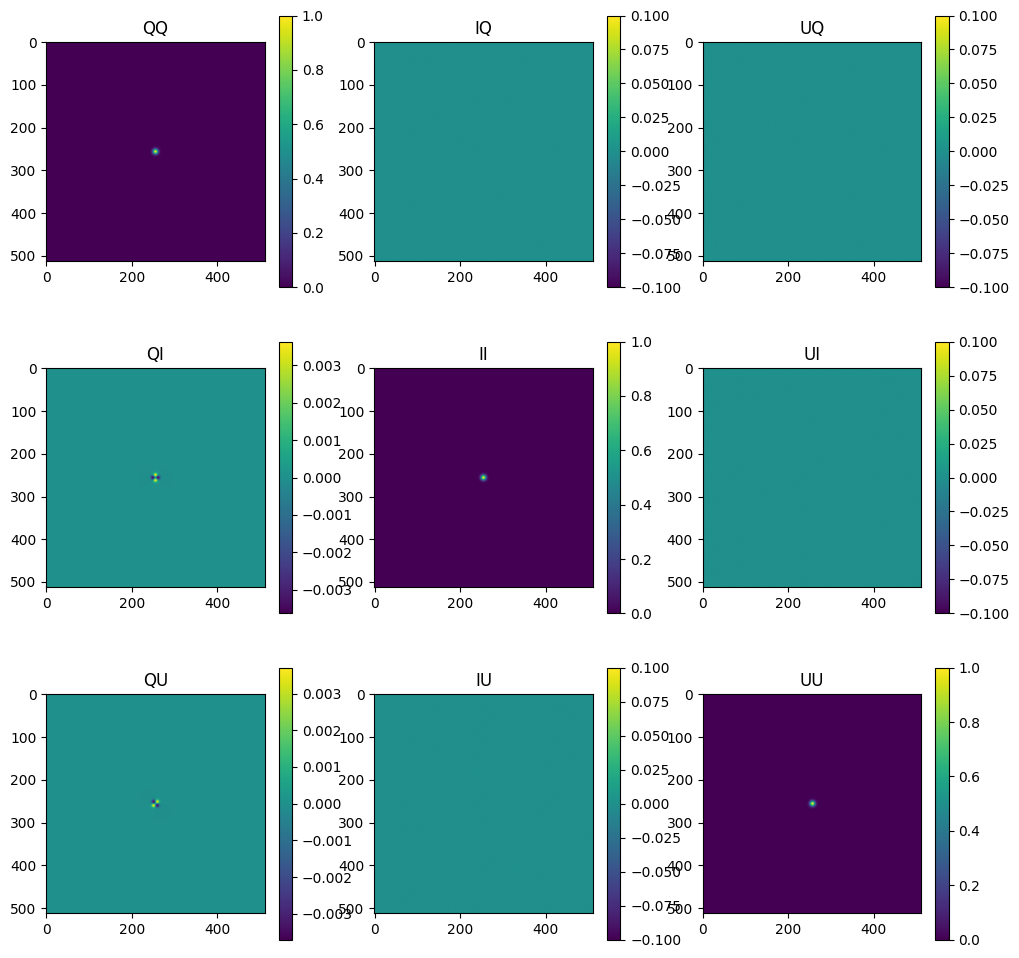

In [18]:
fig, ax = plt.subplots(3,3, figsize=(12,12))

qq = ax[0,0].imshow(abeam.beam_matrix['QQ']) # Q->Q leakage
ax[0,0].set_title('QQ')
plt.colorbar(qq, ax=ax[0,0])

qi = ax[1,0].imshow(abeam.beam_matrix['QI']) # Q->I leakage
ax[1,0].set_title('QI')
plt.colorbar(qi, ax=ax[1,0])

qu = ax[2,0].imshow(abeam.beam_matrix['QU']) # Q->U leakage
ax[2,0].set_title('QU')
plt.colorbar(qu, ax=ax[2,0])

iq = ax[0,1].imshow(abeam.beam_matrix['IQ']) # I->Q leakage
ax[0,1].set_title('IQ')
plt.colorbar(iq, ax=ax[0,1])

ii = ax[1,1].imshow(abeam.beam_matrix['II']) # I->I leakage
ax[1,1].set_title('II')
plt.colorbar(ii, ax=ax[1,1])

iu = ax[2,1].imshow(abeam.beam_matrix['IU']) # I->U leakage
ax[2,1].set_title('IU')
plt.colorbar(iu, ax=ax[2,1])

uq = ax[0,2].imshow(abeam.beam_matrix['UQ']) # U->Q leakage
ax[0,2].set_title('UQ')
plt.colorbar(uq, ax=ax[0,2])

ui = ax[1,2].imshow(abeam.beam_matrix['UI']) # U->I leakage
ax[1,2].set_title('UI')
plt.colorbar(ui, ax=ax[1,2])

uu = ax[2,2].imshow(abeam.beam_matrix['UU']) # U->U leakage
ax[2,2].set_title('UU')
plt.colorbar(uu, ax=ax[2,2])

plt.show()

Next, we would like to see the leakage spectra. We'll need some information about the spectrum for the analysis, which we write into ```spectrum_params```. Then, we can find the $\ell$ values and the leakage spectra.

In [19]:
spectrum_params = {'sky_decomp': [1,0,0], # IQU decomposition, usually [1,0,0]
                   'delta_ell': 10., # spacing between ell bins
                   'ell_max': 8000, # maximum ell value to analyze; if using CMB_compare, do not exceed 10000
                   'choose_normalization': 'TT', # spectrum to normalize to, usually 'TT'
                   }

ell_abeam, spectra_abeam = mmt_tools.get_mmt_leakage(abeam, spectrum_params)

delta_ell = 85
delta_ell = 85


We can look at the leakage spectra on their own, or compare them to the CMB power spectra:

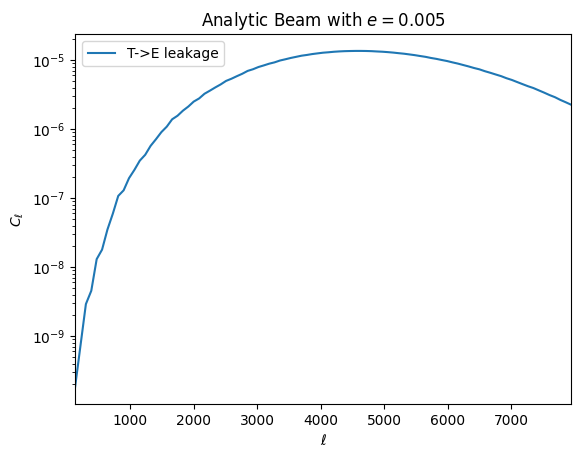

In [20]:
mmt_tools.make_leakage_plot(ell_abeam, spectra_abeam, f"Analytic Beam with $e=${analytic_beam_params['ellipt']}", leakage=['TE'], CMB_compare=False)

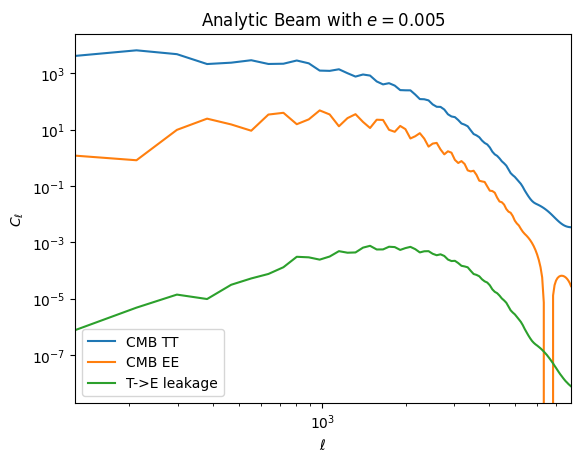

In [21]:
mmt_tools.make_leakage_plot(ell_abeam, spectra_abeam, f"Analytic Beam with $e=${analytic_beam_params['ellipt']}", leakage=['TE'], CMB_compare=True)

## Exercises

1. Change the ellipticity to 0.003, 0.01, and 0.03. What changes about the beam and the leakage?
2. Change the pixel_size to 0.05/60., 0.1/60., and 1./60. What changes about the beam and the leakage?
3. Change the beam_fwhm between 1.5 arcmin (LAT-like beam) and 15 arcmin (SAT-like beam). What changes do you notice? What about for an intermediate value (5 or 10 arcmin)?
4. Try looking at the beam window function (```leakage=['TT']```). What do you notice? What does its shape tell you about the beam? How does it vary with beam size?
5. We looked at T$\rightarrow$E leakage. Now add ```'TB'``` to the ```leakage``` list in ```make_leakage_plot```. How do things change? Why might that be?

## HFSS Simulated Beam

Now that we know some of the basics of how the beams pipeline works, let's try it out with some feedhorn simulations! There are a lot more beam parameters here, because of how we need to interpret the data to make our beams, and it will take longer to run this process, but from the user side, it is very similar.

/Users/laurensaunders/beams_pipeline/make_beams.py:240: RuntimeWarning: invalid value encountered in divide
  image_rax=np.nan_to_num(np.divide(sum_rbax,hits_rbax))
/Users/laurensaunders/beams_pipeline/make_beams.py:241: RuntimeWarning: invalid value encountered in divide
  image_ray=np.nan_to_num(np.divide(sum_rbay,hits_rbay))
/Users/laurensaunders/beams_pipeline/make_beams.py:242: RuntimeWarning: invalid value encountered in divide
  image_rbx=np.nan_to_num(np.divide(sum_rbbx,hits_rbbx))
/Users/laurensaunders/beams_pipeline/make_beams.py:243: RuntimeWarning: invalid value encountered in divide
  image_rby=np.nan_to_num(np.divide(sum_rbby,hits_rbby))
/Users/laurensaunders/beams_pipeline/make_beams.py:244: RuntimeWarning: invalid value encountered in divide
  image_iax=np.nan_to_num(np.divide(sum_ibax,hits_ibax))
/Users/laurensaunders/beams_pipeline/make_beams.py:245: RuntimeWarning: invalid value encountered in divide
  image_iay=np.nan_to_num(np.divide(sum_ibay,hits_ibay))
/Users/lau

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 529
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 527
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 527
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 515


/Users/laurensaunders/beams_pipeline/make_beams.py:607: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  best_fit = opt.fmin_powell(self.min_fun, x0=(np.min(unwrapped_phi), 0.014*freq[zz]/150., 0., 0.), args=(unwrapped_phi, mask))


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 482
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 489
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 494
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 516
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 489
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 587
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 601
Optimization terminated successful

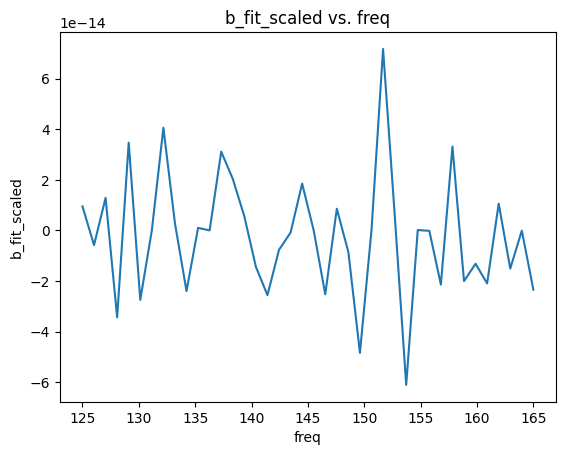

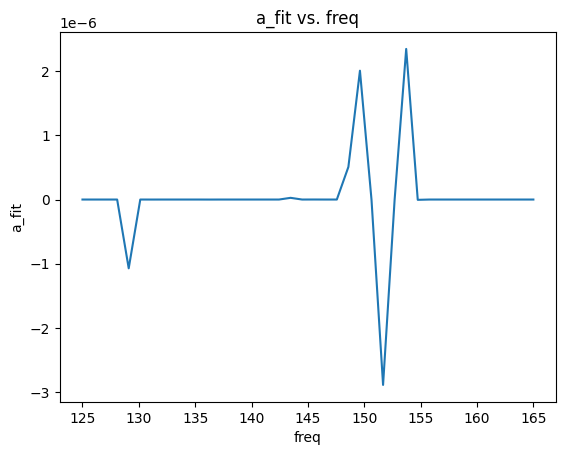

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 529
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 527
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 527
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 515
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 482
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 489
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 494
Optimization terminated successful

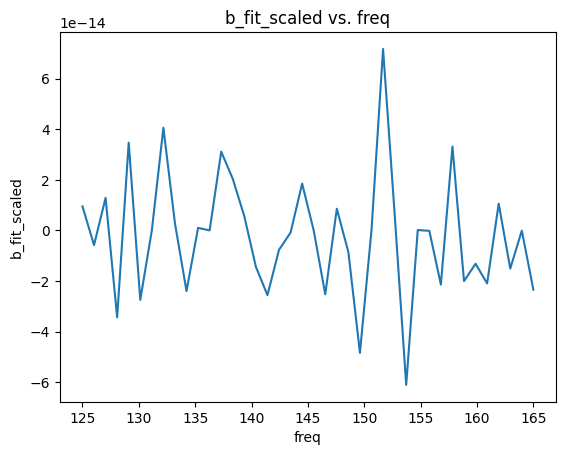

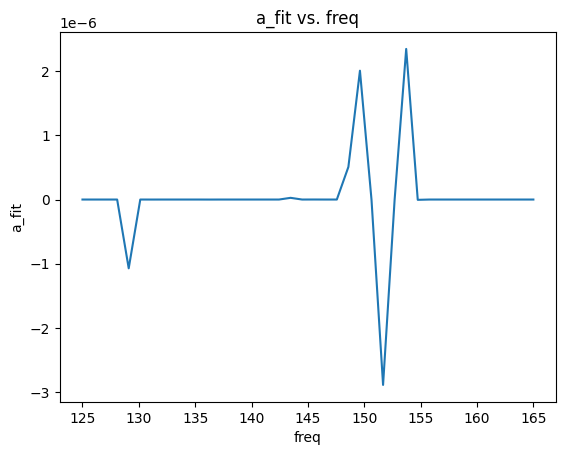

In [7]:
hbeam_params = {'fmin': 125, # lower frequency edge of the band
                'fmax': 165, # upper frequency edge of the band
                'numfreqs': 40, # number of frequencies in between these to analyze
                'folder': {'I': 'hfss_iq/', # where you want to store the I & Q optimization
                           'U': 'hfss_u/', # where you want to store the U optimization
                          },
                'stop_angle': 13., # feedhorn stop angle
                'N': 512, # number of pixels
                'mask_params': {'cen': 44.5, # mask center
                                'telecentricity': 0, # mask telecentricity
                                'savename': 'mask.txt', # filename to store the mask
                               },
                'center_freqs': [150], # center frequency
                'beam_fwhm': 1.5, # FWHM of the beam
                'pixel_size': 0.25/60., # pixel size in degrees
               }
hbeam_params['npix'] = hbeam_params['N']

hbeam = make_beams.HFSSBeam(hbeam_params) # this step is very verbose

```hbeam``` now holds all of the information we need about this beam. Just like before, we can make some plots of the beam leakage and make sure it looks the way we expect it to.

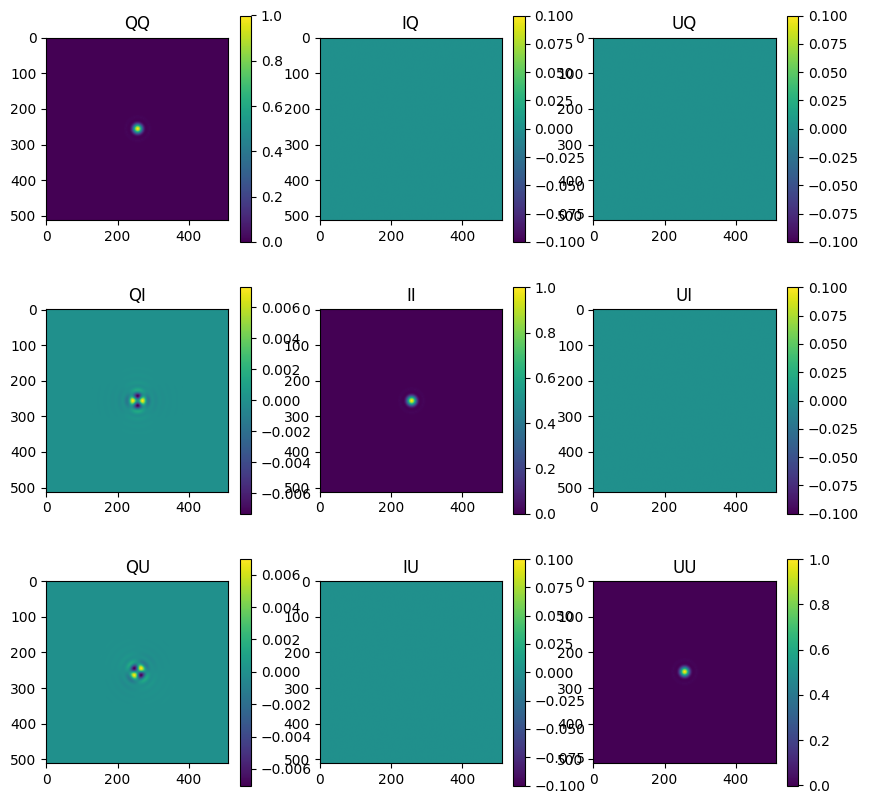

In [8]:
fig, ax = plt.subplots(3,3, figsize=(10,10))

qq = ax[0,0].imshow(hbeam.beam_matrix['QQ']) # Q->Q leakage
ax[0,0].set_title('QQ')
plt.colorbar(qq, ax=ax[0,0])

qi = ax[1,0].imshow(hbeam.beam_matrix['QI']) # Q->I leakage
ax[1,0].set_title('QI')
plt.colorbar(qi, ax=ax[1,0])

qu = ax[2,0].imshow(hbeam.beam_matrix['QU']) # Q->U leakage
ax[2,0].set_title('QU')
plt.colorbar(qu, ax=ax[2,0])

iq = ax[0,1].imshow(hbeam.beam_matrix['IQ']) # I->Q leakage
ax[0,1].set_title('IQ')
plt.colorbar(iq, ax=ax[0,1])

ii = ax[1,1].imshow(hbeam.beam_matrix['II']) # I->I leakage
ax[1,1].set_title('II')
plt.colorbar(ii, ax=ax[1,1])

iu = ax[2,1].imshow(hbeam.beam_matrix['IU']) # I->U leakage
ax[2,1].set_title('IU')
plt.colorbar(iu, ax=ax[1,2])

uq = ax[0,2].imshow(hbeam.beam_matrix['UQ']) # U->Q leakage
ax[0,2].set_title('UQ')
plt.colorbar(uq, ax=ax[0,2])

ui = ax[1,2].imshow(hbeam.beam_matrix['UI']) # U->I leakage
ax[1,2].set_title('UI')
plt.colorbar(ui, ax=ax[2,1])

uu = ax[2,2].imshow(hbeam.beam_matrix['UU']) # U->U leakage
ax[2,2].set_title('UU')
plt.colorbar(uu, ax=ax[2,2])

plt.show()

We would again like to see the leakage spectra. We'll use the same ```spectrum_params``` as before, for simplicity. Then, we can find the $\ell$ values and the leakage spectra.

In [9]:
spectrum_params = {'sky_decomp': [1,0,0], # IQU decomposition, usually [1,0,0]
                   'delta_ell': 10., # spacing between ell bins
                   'ell_max': 6000, # maximum ell value to analyze; if using CMB_compare, do not exceed 10000
                   'choose_normalization': 'TT', # spectrum to normalize to, usually 'TT'
                   }

ell_hbeam, spectra_hbeam = mmt_tools.get_mmt_leakage(hbeam, spectrum_params)

delta_ell = 85
delta_ell = 85


We can look at the leakage spectra on their own, or compare them to the CMB power spectra:

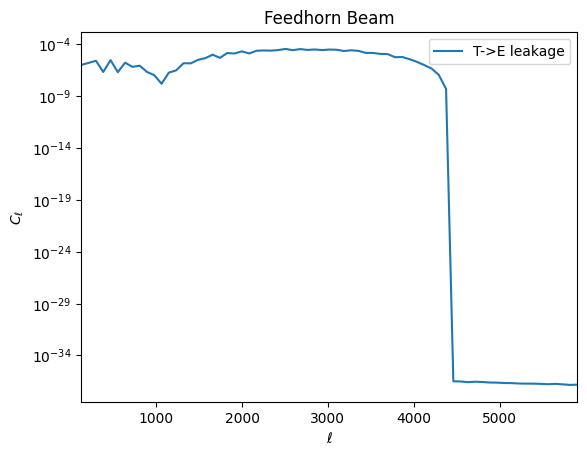

In [10]:
mmt_tools.make_leakage_plot(ell_hbeam, spectra_hbeam, 'Feedhorn Beam', leakage=['TE'], CMB_compare=False)

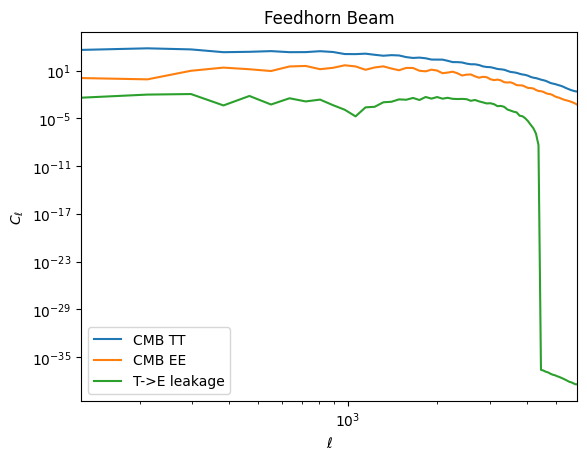

In [11]:
mmt_tools.make_leakage_plot(ell_hbeam, spectra_hbeam, 'Feedhorn Beam', leakage=['TE'], CMB_compare=True)

## Exercises

Now that you know how to use the analytic and file-based pipeline, you can try changing some parameters to see how they affect the leakage spectra. Try the exercises from the Analytic Beam section again, this time with the HFSS beam (skip the T$\rightarrow$B and E$\rightarrow$B leakage exercises, as they will not work with the simulation). Another thing you can change is the stop_angle, which is determined by a telescope's optics (f/#). What do you notice?